In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
%matplotlib inline

In [2]:
huc8=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_6.shp')
huc8= huc8.to_crs({'init': 'epsg:3732'})
huc8['area']=huc8.area

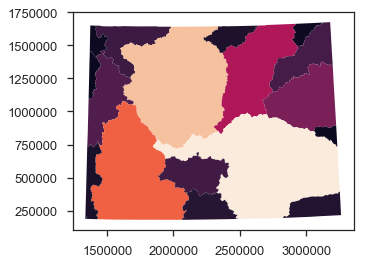

In [4]:
huc8.plot(column='Shape_Area')

In [28]:
df= pd.read_csv(r'M:/critical/imputed.csv')

In [51]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
crs = {'init': 'epsg:3732'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)

geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')

In [4]:
pts=gpd.read_file(r'd:\jupyter\data.shp')

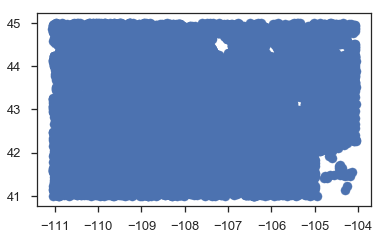

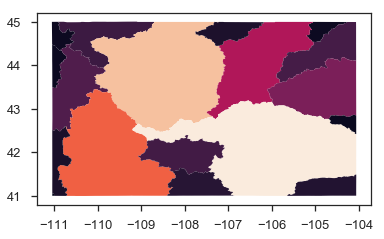

In [5]:
pts.plot()
huc8.plot(column='Shape_Area')

In [6]:
points_with_basin=gpd.sjoin(pts, huc8, how='inner', op='intersects')

In [7]:
points_with_basin.columns

Index(['Unnamed_ 0', 'u_dn_ppm', 'u_fl_ppm', 'ag_ppm', 'al_pct', 'as_ppm',
       'au_ppm', 'b_ppm', 'ba_ppm', 'be_ppm', 'bi_ppm', 'ca_pct', 'cd_ppm',
       'ce_ppm', 'cl_ppm', 'co_ppm', 'cr_ppm', 'cs_ppm', 'cu_ppm', 'dy_ppm',
       'eu_ppm', 'fe_pct', 'hf_ppm', 'k_pct', 'la_ppm', 'li_ppm', 'lu_ppm',
       'mg_pct', 'mn_ppm', 'mo_ppm', 'na_pct', 'nb_ppm', 'ni_ppm', 'p_ppm',
       'pb_ppm', 'rb_ppm', 'sb_ppm', 'sc_ppm', 'se_ppm', 'sm_ppm', 'sn_ppm',
       'sr_ppm', 'ta_ppm', 'tb_ppm', 'th_ppm', 'ti_ppm', 'v_ppm', 'w_ppm',
       'y_ppm', 'yb_ppm', 'zn_ppm', 'zr_ppm', 'longitude', 'latitude',
       'geometry', 'index_right', 'HU_2_NAME', 'HU_4_NAME', 'HU_6_NAME',
       'HUC_6', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

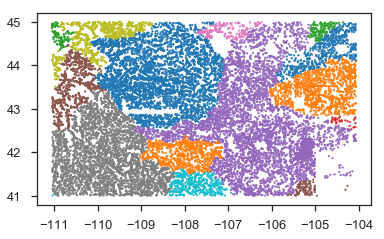

In [9]:
points_with_basin.plot(column='HU_6_NAME', s=3)

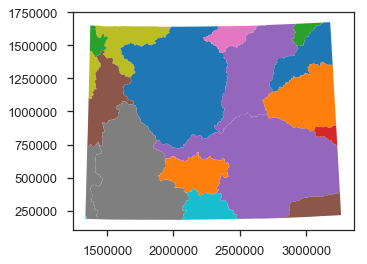

In [5]:
huc8.plot('HU_6_NAME')

In [3]:
bedrock=gpd.read_file(r'J:\Geology\WSGS\GIS\bedrock.shp')
bedrock= bedrock.to_crs({'init': 'epsg:3732'})

In [ ]:
test0=gpd.overlay(bedrock.iloc[1:],huc8.loc[1:], how='intersection')
test0['area'] = test0.area
test0.to_csv('J:/Geology/WSGS/intersection.csv')

In [ ]:
test1=test0.groupby(['HU_6_NAME','Unit_Name']).sum()['area'].unstack(level=0)

In [ ]:
basinNames=test1.columns

In [26]:
100*(test1[basinNames[0]]/huc8[huc8['HU_6_NAME']==basinNames[0]]['area'].values).values

array([        nan,  0.18560362,  1.72423642,         nan,         nan])

In [27]:
for i in range(len(basinNames)):
    test1[basinNames[i]+' percentage']=100*(test1[basinNames[i]]/huc8[huc8['HU_6_NAME']==basinNames[i]]['area'].values).values

In [28]:
test1.fillna(0).to_csv('J:/Geology/WSGS/basin_area_formation.csv')

HU_6_NAME,Big Horn,Great Divide Closed Basin,Missouri Headwaters,North Platte,Powder,Snake Headwaters,South Platte,Upper Bear,Upper Green,Upper Snake,...,Great Divide Closed Basin percentage,Missouri Headwaters percentage,North Platte percentage,Powder percentage,Snake Headwaters percentage,South Platte percentage,Upper Bear percentage,Upper Green percentage,Upper Snake percentage,White-Yampa percentage
Unit_Name,,,,,,,,,,,,,,,,,,,,,
"Ankareh Formation, Thaynes Limestone, Woodside Shale, and Dinwoody Formation",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.588009e+09,0.000000e+00,1.725527e+09,3.833226e+09,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,2.072830,0.000000,4.135252,0.930488,0.000000,0.000000
"Chugwater Formation (N, NE), or Chugwater Group or Formation (S)",9.888575e+08,5.530830e+07,0.000000e+00,6.158886e+09,1.096239e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.051654,0.000000,0.999635,0.042038,0.000000,0.000000,0.000000,0.000000,0.000000,0.042665
Chugwater and Dinwoody Formations,9.186374e+09,0.000000e+00,1.386780e+07,9.492462e+06,4.724733e+08,6.817488e+08,0.000000e+00,0.000000e+00,5.553250e+08,2.350961e+07,...,0.000000,0.072421,0.001541,0.181182,0.546037,0.000000,0.000000,0.134801,0.131214,0.000000
Chugwater and Goose Egg Formations,0.000000e+00,0.000000e+00,0.000000e+00,1.709722e+09,2.512604e+08,0.000000e+00,4.655459e+07,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.277501,0.096352,0.000000,0.081682,0.000000,0.000000,0.000000,0.000000
Mafic intrusive rocks,0.000000e+00,0.000000e+00,0.000000e+00,4.209542e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.068324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.097203


In [29]:
test1.iloc[0:,int(np.shape(test1)[1]/2):].fillna(0)

HU_6_NAME,Big Horn percentage,Great Divide Closed Basin percentage,Missouri Headwaters percentage,North Platte percentage,Powder percentage,Snake Headwaters percentage,South Platte percentage,Upper Bear percentage,Upper Green percentage,Upper Snake percentage,White-Yampa percentage
Unit_Name,,,,,,,,,,,
"Ankareh Formation, Thaynes Limestone, Woodside Shale, and Dinwoody Formation",0.000000,0.000000,0.000000,0.000000,0.000000,2.072830,0.000000,4.135252,0.930488,0.000000,0.000000
"Chugwater Formation (N, NE), or Chugwater Group or Formation (S)",0.185604,0.051654,0.000000,0.999635,0.042038,0.000000,0.000000,0.000000,0.000000,0.000000,0.042665
Chugwater and Dinwoody Formations,1.724236,0.000000,0.072421,0.001541,0.181182,0.546037,0.000000,0.000000,0.134801,0.131214,0.000000
Chugwater and Goose Egg Formations,0.000000,0.000000,0.000000,0.277501,0.096352,0.000000,0.081682,0.000000,0.000000,0.000000,0.000000
Mafic intrusive rocks,0.000000,0.000000,0.000000,0.068324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.097203


In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Select South Amarica and some columns
countries = world[world['continent'] == "South America"]

countries = countries[['geometry', 'name']]

# Project to crs that uses meters as distance measure
countries = countries.to_crs('+init=epsg:3395')

capitals = capitals.to_crs('+init=epsg:3395')

In [147]:
cc2=country_cores[['name', 'name_2']]
cc2['area']=country_cores.area
cc2

,name,name_2,area
0,Argentina,Santiago,3.474672e+11
1,Chile,Santiago,1.848383e+11
2,Argentina,Montevideo,2.233865e+11
3,Argentina,Montevideo,1.856582e+07
4,Uruguay,Montevideo,1.810873e+11
5,Peru,Quito,8.521896e+08
6,Ecuador,Quito,2.497435e+11
7,Peru,Quito,1.000652e+11
8,Argentina,Buenos Aires,2.427096e+11
9,Uruguay,Montevideo,1.115099e-05


In [154]:
argen=cc2[cc2['name']=='Argentina'].groupby('name_2').sum()

In [163]:
argarea=countries[countries['name']=='Argentina'].area.values

In [165]:
(argen/argarea)*100

,area
name_2,
Asuncion,7.508552
Buenos Aires,5.632170
Montevideo,5.184200
Santiago,8.063111
Sucre,1.260590


In [ ]:
import time
runned=[]
for i in range(1,10):
    t0=time.time()
    gpd.overlay(bedrock.iloc[1:i],huc8.loc[1:], how='intersection')
    t1=time.time()
    runned.append(t1-t0)

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x000001B93A9F32B0>>
Traceback (most recent call last):
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\rtree\index.py", line 875, in __del__
    self.destroy()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\rtree\index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'


In [ ]:
plt.plot(runned)

In [ ]:
runned

In [1]:
import time
